### Objective: 
Anthony, Tong and I have decided to do the ['Melbourne University AES/MathWorks/NIH Seizure Prediction'](https://www.kaggle.com/c/melbourne-university-seizure-prediction) competition. 

The goal of this competition is to develop a classifier that distinguishes betewen a non seizure (pre-ictal) and (interictal) seziure activity in humans. 

Here I am doing some initial exploratory analysis. 

In this notebook, I will first look at the data numerically, and then look at several of the training examples. 

In [196]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bokeh.plotting import figure, output_file, output_notebook, show
from bokeh.colors import RGB
import scipy
import seaborn as sns
from os.path import join,dirname, split
from os import listdir
from scipy.io import loadmat
from GraphingSetup import configure_plots, create_tableau_colors
%matplotlib inline
configure_plots()
tableau = create_tableau_colors()

sns.set_style('white')
sns.set_context('talk')

In [4]:
def convert_index_to_timedelta(index, sampling_rate=400):
    """converts the index to time delta"""
    index = [i*1.0/sampling_rate for i in index]
    return pd.to_timedelta(index,'s')
    

def load_data(path,convert_index=True):
    """converts the data to a pandas object
    Parameters: 
        path(str): absolute path to the m file 
        convert_index(bool): if True, convert the index to a time delta
    Returns: 
        (data,sampling_rate,sequence):(pd.DataFrame, int, int) 
    """
    # load the matlab file and extract the data
    data = loadmat(path)['dataStruct']
    
    # get the sampling rate and cast to int
    sampling_rate = int(data['iEEGsamplingRate'][0][0])
    
    #extract the iEEG traces and electrode channel data and place into a data frame
    traces = data['data'][0][0]
    channels = data['channelIndices'][0][0][0]
    df = pd.DataFrame(traces, columns = channels)
    
    if convert_index: 
        df.index = convert_index_to_timedelta(df.index, sampling_rate)
    
    #get the sequence collection number if present (not present in test)
    sequence = -1
    if 'sequence' in data.dtype.names:
        sequence =int(data['sequence'])

    return df, sampling_rate, sequence

### Get some data
Below, I load some of the data for one of the patients. 
As I understand the data 

In [5]:
base = '/Users/crivera5/Documents/NonIntuitProjects/Kaggle/KaggleEEG'
train1_path = join(base, 'train_1')
train2_path = join(base, 'train_2')
train3_path = join(base, 'train_3')

In [6]:
data = load_data(join(train1_path,'1_1_0.mat'))

In [7]:
traces1 =  data[0].resample('1s').mean()

In [8]:
def scale(x):
    '''scales a series by subtracting the mean and dividing by std'''
    return (x-np.mean(x))/np.std(x)

def plot_ts(tsdata,columns = -1): 
    """plots the timeseries
    Parameters: 
        tsdata(pd.DataFrame): the data 
        column: the columns to use
    """
    
    if columns>0: 
        tsdata = tsdata.iloc[:,columns]
    
    # scale the data 
    scaled = tsdata.apply(scale)
    
    
    # unstack the data, reset the columns and change the names
    ts = pd.DataFrame(scaled.unstack())
    ts.reset_index(inplace = True)
    ts.columns = ['Position', 'Time','Signal']
    
    # plot the data
    
    ax = sns.tsplot(time="Time", value="Signal",data = ts ,condition = 'Position', unit = 'Position')
    
    sns.despine()
    return ax


def plot_corr_matrix(df):
    """Plots a heat map of the correlation matrix"""
    
    # compute the corr matrix
    corr = df.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1,vmax = 1,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=1, cbar_kws={"shrink": .5}, ax=ax)
    
    return ax



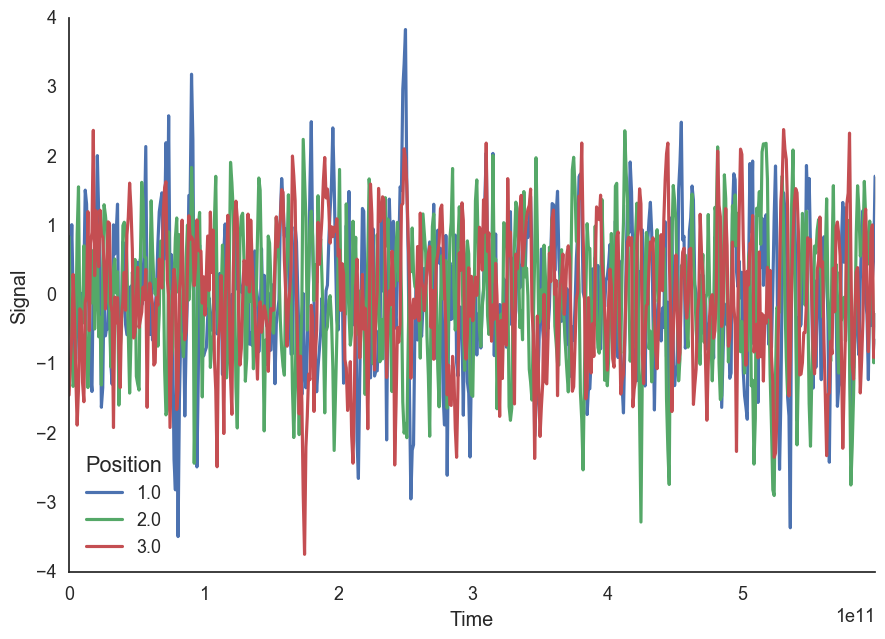

In [9]:
plot_ts(traces1,range(3))

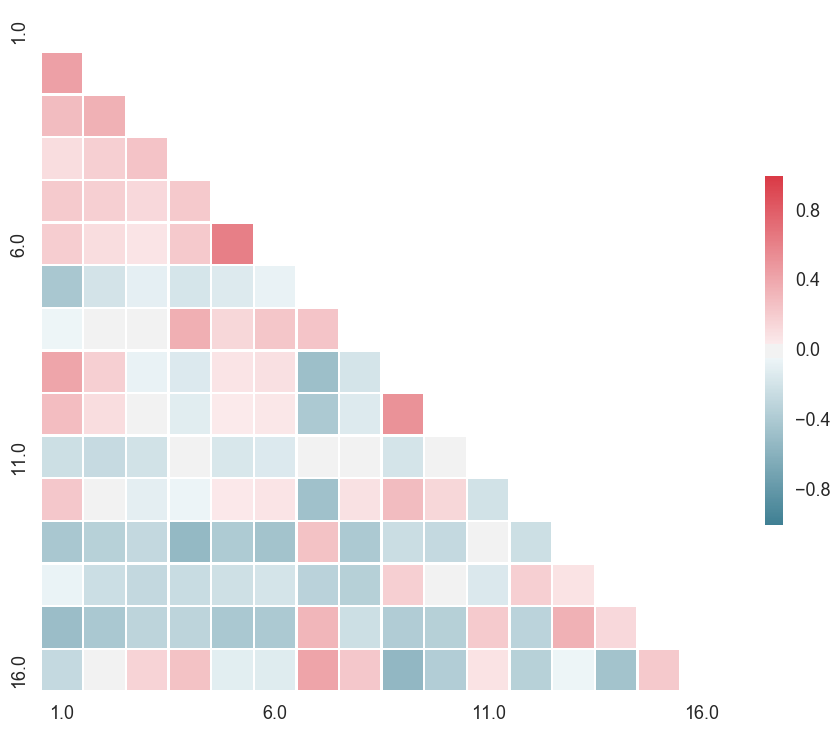

In [10]:
plot_corr_matrix(data[0])

### Investigating how to look at the data. 


In [11]:
output_notebook()
p = figure(title="simple line example", x_axis_label='x', y_axis_label='y')
p.line(traces1.index, traces1.iloc[:,4], color = 'red')

show(p)

Loading BokehJS ...

In [134]:
def plot_with_bokeh(data, scale_data=True):
    """Plots the data using bokeh
    Parameters:
        data(pd.DataFrame): The data, assume all columns numeric and and index has the x axis
        scale_data(bool): if True, scale the data
    Returns:
        None
    """
    
    colors = [(c[0]*255,c[1]*255,c[2]*255) for c in tableau]
    # if scaling desired, scale the data
    if scale_data: 
        if isinstance(data, pd.Series):
            data = pd.DataFrame(scale(data))

    else:
        data = data.apply(scale)    
        
    output_notebook()
    ncols = data.shape[1]
    p = figure(title="iEEG intensity versus Time", x_axis_label='Time(s)', y_axis_label='Intensity')
    for i in range(ncols):
        p.line(data.index, data.iloc[:,i],line_color = colors[i],line_width = 1.5)
        p.circle(data.index, data.iloc[:,i], line_color = tableau[i], fill_color = colors[i],size = 8, alpha = 0.8)
    show(p)
    return p



In [138]:
_=plot_with_bokeh(traces1)

Loading BokehJS ...

### Determine how many files there are per patient
Below, I count the number of files per patient. 

In [136]:
from collections import defaultdict
def parse_filename(filename):
    """Parses m filename to get the pertinent information"""
    
    #strip out the .mat 
    filename = filename.replace('.mat', '')
    
    # parse the remaing part 
    return [int(part) for part in filename.split('_')]


def count_files(directory):
    """counts the number of files per condition for each patient in a directory"""
    
    # parse the files 
    files = [ parse_filename(f) for f in listdir(directory) if f.endswith('.mat')]
    
    # go through each file and count
    interictal ={}
    postictal = {}
    
    for f in  files: 
        if f[2] == 0:
            interictal.setdefault(f[0],0)
            interictal[f[0]]+=1
        else:
            postictal.setdefault(f[0],0)
            postictal[f[0]]+=1
    return interictal, postictal

In [137]:
map(count_files, [train1_path, train2_path, train3_path])

[({1: 1152}, {1: 150}), ({2: 2196}, {2: 150}), ({3: 2244}, {3: 150})]

### Code to extract stats from a a data set
Although Anthony has already written this, I want to start writing code to extract pertinent features. 


In [216]:
def extract_base_stats(data,patient=1, number=1,condition=0):
    """extracts the mean, variance, skew and kurtosis of a given data set of data set
    data(dataframe): a given data set
    patient(int): the patient
    number(int): the trace number
    conditon(int): 0 if interictal or 1 if ictal
    """
    mean = data.mean()
    var = data.var()
    skew = data.skew()
    kurtosis = data.kurtosis()
    
    l = len(mean)
    # format the namea
    
    def create_tuple(name):
        return [(name,str(i+1)) for i in xrange(l)]
    columns = create_tuple('mean') + create_tuple('variance') + create_tuple('skew') + create_tuple('kurtosis')
    
    
    res = pd.DataFrame(pd.concat([mean, var, skew, kurtosis])).T
    res.columns = pd.MultiIndex.from_tuples(columns, names = ['Statistic', 'Channel'])
    res.index = pd.MultiIndex.from_tuples([(patient, number,condition)],names = ['Patient','TraceNumber','Condition'])
    return res


def get_files():
    """gets teh file names"""
    base = '/Users/crivera5/Documents/NonIntuitProjects/Kaggle/KaggleEEG'
    path1 = join(base, 'train_1')
    path2 = join(base, 'train_2')
    path3= join(base, 'train_3')
    
    def get_fs(path):
        return [join(path, f) for f in listdir(path) if f.endswith('.mat')]
    
    return get_fs(path1) + get_fs(path2) + get_fs(path3)
    
def get_stats_from_one_file(filename):
    """gets the stats from one file
    Parameters:
        filename(str): absolute path to the file
    Return(df): 1 row data frame with the stats

    """
    try: 
    # get the data
        data = load_data(filename)[0]
    # get the file name parts
        patient,number, condition = parse_filename(split(filename)[1])
    
    # get the stats and return
        return extract_base_stats(data, patient,number, condition)
    except ValueError:
        return None
    
    
def get_stats():
    """function to get the stats and put into a data frame """
    #get the files names
    files = get_files()
    
    # use a slow for loop to get the res
    return pd.concat(map(get_stats_from_one_file,files))
        


In [217]:
stats=get_stats()

In [218]:
stats.head()

Statistic                          mean                                \
Channel                               1         2         3         4   
Patient TraceNumber Condition                                           
1       1000        0          0.000013  0.018979  0.110020 -0.070512   
        1001        0         -0.000095  0.001571  0.091439 -0.058023   
        1002        0         -0.000210  0.001243  0.114901 -0.068601   
        1003        0          0.000038 -0.008507  0.058894 -0.091241   
        1004        0         -0.000029 -0.012850  0.061407 -0.057556   

Statistic                                                              \
Channel                               5         6         7         8   
Patient TraceNumber Condition                                           
1       1000        0          0.121365 -0.086002 -0.047102 -0.205388   
        1001        0          0.106022 -0.074010 -0.040114 -0.164815   
        1002        0          0.111166 -0.093471 -0.044191 -0.217447   
        1003        0          0.042426 -0.090234 -0.012338 -0.138912   
        1004        0          0.043755 -0.077375 -0.020182 -0.126756   

Statistic                                            ...     kurtosis  \
Channel                               9        10    ...            7   
Patient TraceNumber Condition                        ...                
1       1000        0         -0.123931 -0.229047    ...     4.590851   
        1001        0         -0.102871 -0.189988    ...     5.159664   
        1002        0         -0.133188 -0.236459    ...     2.743250   
        1003        0         -0.082885 -0.166484    ...     5.005838   
        1004        0         -0.082875 -0.155739    ...     4.630746   

Statistic                                                              \
Channel                               8         9        10        11   
Patient TraceNumber Condition                                           
1       1000        0          6.542956  2.942252  5.147886  7.475247   
        1001        0          9.993204  3.015073  3.818313  7.209260   
        1002        0          2.901863  1.300645  2.729763  4.957086   
        1003        0          7.186119  5.411513  5.487325  8.045566   
        1004        0          6.186982  4.054087  4.353436  5.924407   

Statistic                                                               \
Channel                              12        13        14         15   
Patient TraceNumber Condition                                            
1       1000        0          8.010892  9.652721  5.929777  14.917701   
        1001        0          7.898366  7.774518  5.580406  13.173166   
        1002        0          5.975457  4.964344  4.361349  10.261859   
        1003        0          5.832695  4.318530  7.658966   5.973562   
        1004        0          5.921144  6.145896  7.418332   7.506569   

Statistic                                
Channel                              16  
Patient TraceNumber Condition            
1       1000        0          7.071571  
        1001        0          5.311100  
        1002        0          4.160729  
        1003        0          4.001372  
        1004        0          3.604297  

[5 rows x 64 columns]

In [222]:
# save the the stats
import feather
feather.write_dataframe(stats, '/Users/crivera5/Documents/NonIntuitProjects/Kaggle/KaggleEEG/data_local/base_stats.feather')